In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from resnets_utils import *
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow


from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

import matplotlib.pyplot as plt


%matplotlib inline
np.random.seed(1)
tf.random.set_seed(2)
tf.keras.backend.set_learning_phase(True) 

2023-12-29 16:09:00.169460: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-29 16:09:00.169607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-29 16:09:00.172929: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-29 16:09:00.183046: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-29 16:09:01.226269: W tensorflow/compiler/tf2

In [2]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

In [3]:
BATCH_SIZE = 4
IMG_SIZE = (64, 64)
directory = "data/chest_xray/train/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 5840 files belonging to 3 classes.
Using 4672 files for training.


2023-12-29 16:09:03.656659: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-29 16:09:03.723878: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-29 16:09:03.724265: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 5840 files belonging to 3 classes.
Using 1168 files for validation.


0 253
0 255
0 254
0 254


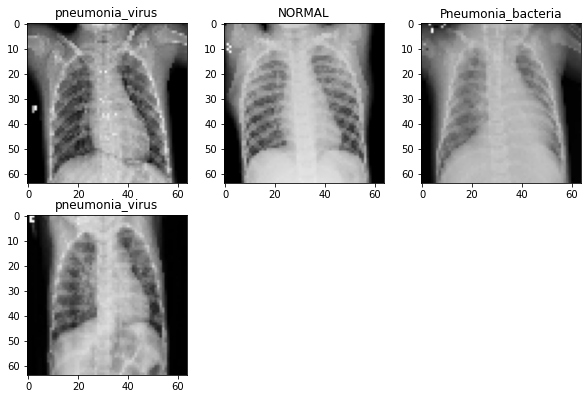

In [4]:
class_names = train_dataset.class_names
# class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(4):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        print(images[i].numpy().astype("uint8").min(),images[i].numpy().astype("uint8").max())
        plt.title(class_names[labels[i]])
        # plt.axis("off")

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [6]:
def identity_block(X, f, filters, initializer=Constant(1), training=True):
    """
    Implementation of the identity block as defined in the assignment.

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    initializer -- python function, used to initialize weights

    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. You'll need this later to add back to the main path.
    X_shortcut = X

    # First component of main path
    X = Conv2D(
        filters=F1,
        kernel_size=(1, 1),
        strides=(1, 1),
        padding="valid",
        kernel_initializer=initializer,
    )(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = ReLU()(X)

    # Second component of main path
    X = Conv2D(
        filters=F2,
        kernel_size=(f, f),
        strides=(1, 1),
        padding="same",
        kernel_initializer=initializer,
    )(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = ReLU()(X)

    # Third component of main path
    X = Conv2D(
        filters=F3,
        kernel_size=(1, 1),
        strides=(1, 1),
        padding="valid",
        kernel_initializer=initializer,
    )(X)
    X = BatchNormalization(axis=3)(X, training=training)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = ReLU()(X)

    return X

In [7]:
# UNQ_C2
# GRADED FUNCTION: convolutional_block


def convolutional_block(X, f, filters, s=2, initializer=tf.keras.initializers.glorot_uniform(seed=0) , training=True):
    seed = 0
    """
    Implementation of the convolutional block as defined in Figure 4

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer,
                   also called Xavier uniform initializer.

    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####

    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(
        filters=F1,
        kernel_size=1,
        strides=(s, s),
        padding="valid",
        kernel_initializer=initializer,
    )(X)
    X = BatchNormalization(axis=3)(X,training = training)
    X = ReLU()(X)

    ### START CODE HERE

    ## Second component of main path (≈3 lines)
    X = Conv2D(
        filters=F2,
        kernel_size=f,
        strides=(1, 1),
        padding="same",
        kernel_initializer=initializer,
    )(X)
    X = BatchNormalization(axis=3)(X,training = training)
    X = ReLU()(X)

    ## Third component of main path (≈2 lines)
    X = Conv2D(
        filters=F3,
        kernel_size=1,
        strides=(1, 1),
        padding="valid",
        kernel_initializer=initializer,
    )(X)
    X = BatchNormalization(axis=3)(X,training = training)

    ##### SHORTCUT PATH ##### (≈2 lines)
    X_shortcut = Conv2D(
        filters=F3,
        kernel_size=1,
        strides=(s, s),
        padding="valid",
        kernel_initializer=initializer,
    )(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut,training = training)

    ### END CODE HERE

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = ReLU()(X)

    return X


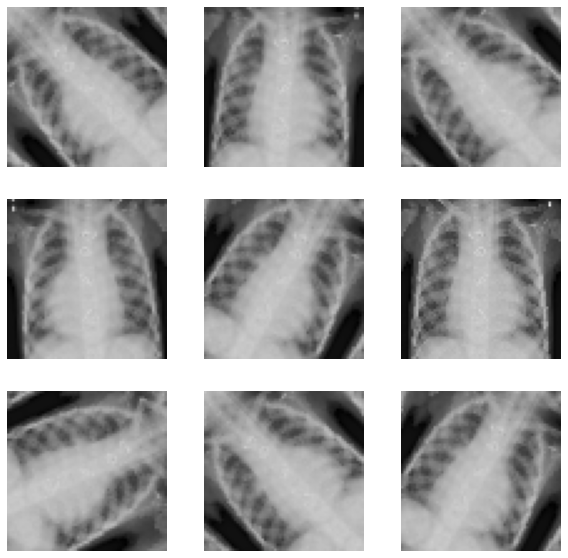

In [8]:
# UNQ_C1
# GRADED FUNCTION: data_augmenter
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    ### START CODE HERE
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2))
    ### END CODE HERE
    
    return data_augmentation

data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [9]:
# UNQ_C3
# GRADED FUNCTION: ResNet50


def ResNet50(input_shape=(64, 64, 3), classes=3, training=False):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    X_input = data_augmenter()(X_input)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X,training)
    X = Activation("relu")(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], s=1,training = training)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])


    ### START CODE HERE

    # Use the instructions above in order to implement all of the Stages below
    # Make sure you don't miss adding any required parameter

    ## Stage 3 (≈4 lines)
    # `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = convolutional_block(X,f =  3, filters =[128,128,512], s=2,  training= training)
   

    # the 3 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])

    

    # Stage 4 (≈6 lines)
    # add `convolutional_block` with correct values of `f`, `filters` and `s` for t
    X = convolutional_block(X,f =  3,filters =  [256,256,1024], s=2, training= training)
    # the 5 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3, [256,256,1024])
    X = identity_block(X, 3, [256,256,1024])
    X = identity_block(X, 3, [256,256,1024])
    X = identity_block(X, 3, [256,256,1024])
    X = identity_block(X, 3, [256,256,1024])

    # Stage 5 (≈3 lines)
    # add `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = convolutional_block(X,f =  3, filters = [512,512,2048], s=2, training= training)

    # the 2 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3, [512,512,2048])
    X = identity_block(X, 3, [512,512,2048])

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D()(X)"
    X = AveragePooling2D(pool_size=(2, 2))(X)

    ### END CODE HERE

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation="softmax", kernel_initializer=glorot_uniform(seed=0))(
        X
    )

    # Create model
    model = Model(inputs=X_input, outputs=X)

    return model

In [10]:
tf.keras.backend.set_learning_phase(True)

model = ResNet50(input_shape=(64, 64, 3), classes=len(class_names))
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 70, 70, 3)            0         ['input_2[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           9472      ['zero_padding2d[1][0]']      
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 64)           256       ['conv2d[1][0]']          

In [11]:
np.random.seed(1)
tf.random.set_seed(2)
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=opt, loss=loss_function, metrics=["accuracy"])

In [12]:
IMG_SHAPE = IMG_SIZE + (3,)

In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = model(image_batch)
print(feature_batch.shape)

2023-12-29 16:09:09.400815: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-29 16:09:09.531244: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


(4, 3)


In [14]:
image_batch.shape 

TensorShape([4, 64, 64, 3])

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define a checkpoint callback to save the model weights during training
checkpoint_path = 'model_checkpoint.h5'
checkpoint_callback = ModelCheckpoint(checkpoint_path, save_weights_only=True, save_best_only=True)

initial_epochs = 1

# Load the model weights if they exist
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)

# Continue training from the last saved parameters
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs, callbacks=[checkpoint_callback])

1168/1168 [==============================] - 63s 54ms/step - loss: 0.3364 - accuracy: 0.8587 - val_loss: 0.8128 - val_accuracy: 0.7217


In [ ]:
# from tensorflow.keras.callbacks import ModelCheckpoint

# # Define a checkpoint callback to save the model weights during training
# checkpoint_path = 'model_checkpoint.h5'
# checkpoint_callback = ModelCheckpoint(checkpoint_path, save_weights_only=True, save_best_only=True)


In [ ]:
# from tensorflow.keras.callbacks import ModelCheckpoint

# # Define a checkpoint callback to save the model weights during training
# checkpoint_path = 'model_checkpoint.h5'
# checkpoint_callback = ModelCheckpoint(checkpoint_path, save_weights_only=True, save_best_only=True)

# initial_epochs = 10

# # Load the model weights if they exist
# if os.path.exists(checkpoint_path):
#     model.load_weights(checkpoint_path)

# # Continue training from the last saved parameters
# history = model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs, callbacks=[checkpoint_callback])

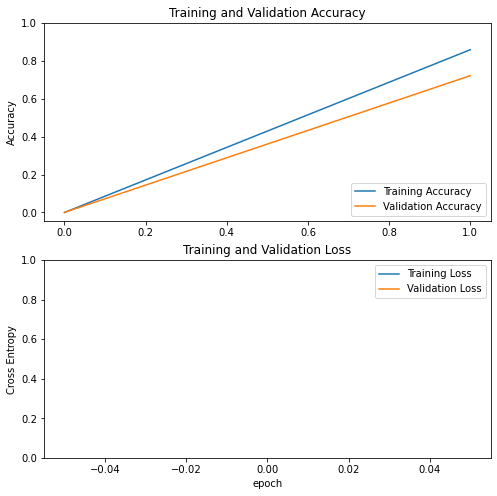

In [17]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# model.save("path/to/save/model_resnet_pnemonia")

In [18]:
import tensorflow as tf

# Clear any existing TensorFlow session and free up GPU memory
tf.keras.backend.clear_session()

# Additional steps to limit GPU memory growth (optional but recommended)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only allocate a fraction of GPU memory
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        # Optionally, set a memory limit for each GPU
        # tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [ ]:
import tensorflow as tf

# Load the SavedModel from the .pb file
model = tf.saved_model.load('path/to/save/model_resnet_pnemonia')

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7f68bc0802b0>